In [3]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy import constants as const

#add relative path to backend
import sys
sys.path.append('../../clean_diag/backend')

import trap_units as si

In [4]:
def solve_hub(J,U,Delta,mu,V,DeltaJ,tau,
              N_steps=1000):
    """
    Solves and evolves (duration of tau) the Hubbard-Hamiltonian for the given
    parameters and ramping. Input parameters as angular frequencies and U,Delta
    as tuple of start and end value.
    """
    Nmax = 2      # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
    d = Nmax + 1

    # --- Define Operators ---
    # Single-site bosonic operators in the truncated Fock space
    a = qt.destroy(d)
    adag = a.dag()
    n_op = adag * a

    # --- Construct Hamiltonian ---
    # Hopping term: -J (a† ⊗ a + a ⊗ a†)
    H_hop = -J* (qt.tensor(adag, a) + qt.tensor(a, adag))

    # Interaction term: (U/2) * [n(n-1)] on each site
    # We subtract the identity appropriately to compute n(n-1)
    H_int = 0.5*(qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                    qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))
    # Define the time-dependent function for the interaction
    def int_func(t, args):
        return args['U0']+ (args['U1']-args['U0'])* t/args['tau']
    int_args = {'U0': U[0], 'U1': U[1], 'tau': tau}
    
    # Chemical potential term (if desired)
    H_mu = -mu* (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

    #tilt potential
    H_tilt = (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))
    # Define the time-dependent function for the tilt
    def tilt_func(t, args):
        return args['D0']+ (args['D1']-args['D0'])* t/args['tau']
    tilt_args = {'D0': Delta[0], 'D1': Delta[1], 'tau': tau}

    #nearest neighbour interaction
    H_nni = V* qt.tensor(n_op, qt.qeye(d)) * qt.tensor(qt.qeye(d), n_op)

    #density induced tunneling
    H_dit = -DeltaJ* (qt.tensor(adag,a)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1) +
                        qt.tensor(a,adag)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1))


    # Total Hamiltonian
    H_static = H_hop + H_mu + H_nni + H_dit
    H = [H_static, [H_int, int_func],[H_tilt, tilt_func]]
    


    # --- Define Initial State ---
    # The product Fock state |1,1> (one boson per site)
    psi0 = qt.tensor(qt.basis(d, 1), qt.basis(d, 1))

    # --- Time Evolution Setup ---
    tlist = np.linspace(0, tau, N_steps)  # Evolve from time 0 to 5 in 101 steps

    # We want to monitor the number operator expectation values at each site.
    e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

    # Create an Options object with store_states=True
    #opts = qt.Options(store_states=True, nsteps=10000)
    opts = {"store_states": True, "nsteps": 10000}

    # Run the evolution and store the full state history
    result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts,
                        args=int_args | tilt_args)
    
    return tlist, result

----------------

# Ramping the Interactions:

In [186]:
# --- Parameters ---
J = 2*np.pi* 100#Hz       # Hopping amplitude
U = (2*np.pi* -1000, 2*np.pi* 3000)       # On-site interaction strength
print(U[0]/2/np.pi,U[1]/2/np.pi)
Delta_const = 2*np.pi*1200
Delta = (Delta_const, Delta_const)        #tilt
print(Delta[0]/2/np.pi,Delta[1]/2/np.pi)

mu = 0.0      # Chemical potential (set to zero for simplicity)
V = 0.        # nearest neighbour interaction energy (due to DDI)
DeltaJ = 0.   # density induced tunneling

tau = 20*si.ms     #time duration of simulation
N_steps = int(1e3)      #number of timesteps

tlist, result = solve_hub(J,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps)



-999.9999999999999 3000.0
1200.0 1200.0


fidelity: 0.987


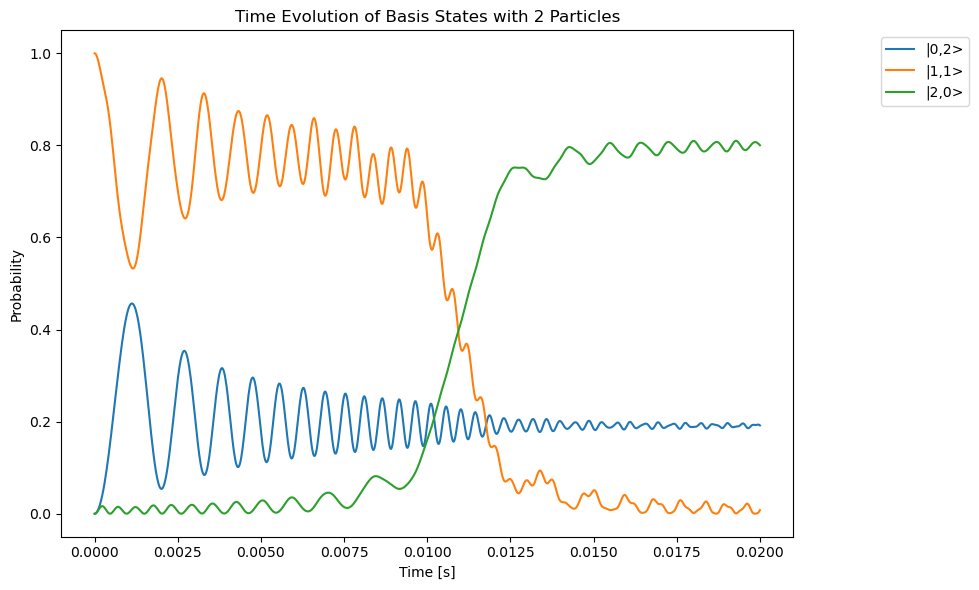

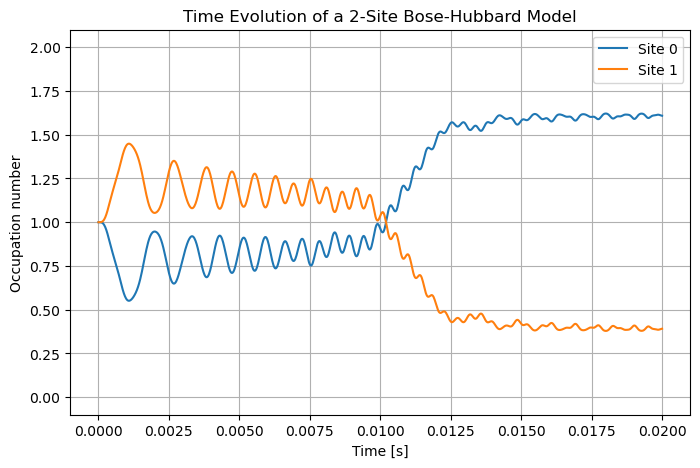

In [187]:
d=3

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2
fid = np.mean(probs[-int(N_steps/5):, 2] + probs[-int(N_steps/5):, 6])
print(f"fidelity: {fid:.3f}")

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == 2]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

# Plot the probability for each 2-particle basis state over time
plt.figure(figsize=(10, 6))
for idx, label in zip(indices_2particles, labels_2particles):
    plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time [s]')
plt.ylabel('Probability')
plt.title('Time Evolution of Basis States with 2 Particles')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.ylim(-0.1,2.1)
plt.xlabel('Time [s]')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()

# Ramping the tilt instead:

In [133]:
9.93*const.value("Bohr magneton")* 2*si.G/si.cm * 800*si.nm /const.h

2223.7233954432318

In [42]:
1*si.uK *const.k / const.h

20836.619123327575

In [45]:
# --- Parameters ---
J = 2*np.pi* 100#Hz       # Hopping amplitude
U_const = 2*np.pi* 1500
U = (U_const, 0*U_const)       # On-site interaction strength
Delta = (2*np.pi* 0, 2*np.pi* 1500)        #tilt

mu = 0.0      # Chemical potential (set to zero for simplicity)
V = 0.        # nearest neighbour interaction energy (due to DDI)
DeltaJ = 0.   # density induced tunneling

tau = 20*si.ms     #time duration of simulation
N_steps = int(1e3)      #number of timesteps

tlist, result = solve_hub(J,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps)



fidelity: 0.974


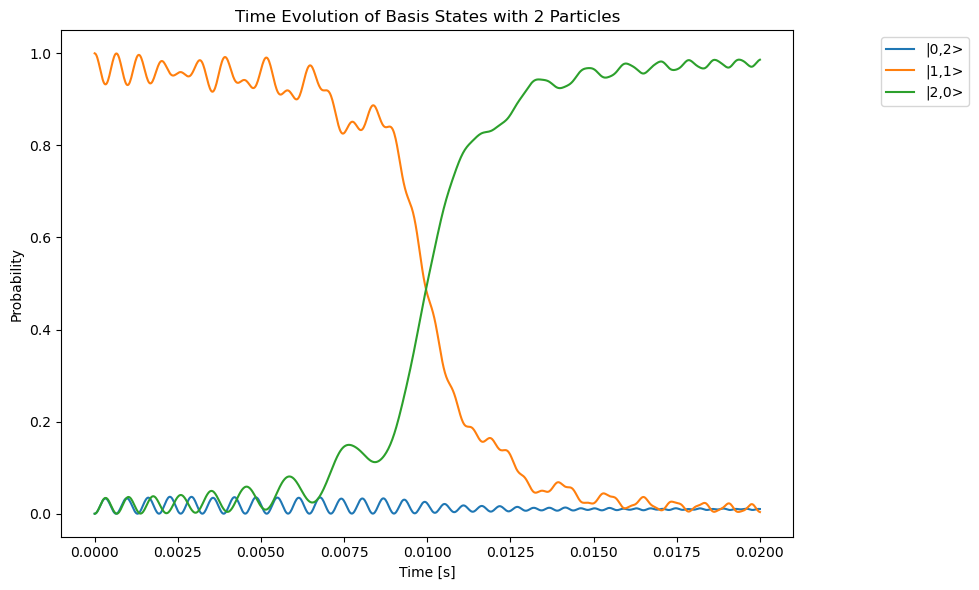

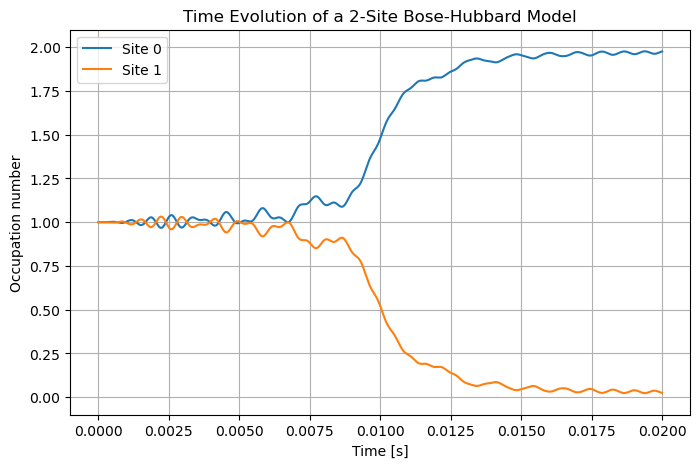

In [46]:
d=3

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2
fid = np.mean(probs[-int(N_steps/5):, 6])
#fid = np.mean(probs[-int(N_steps/5):, 2] + probs[-int(N_steps/5):, 6])
print(f"fidelity: {fid:.3f}")

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == 2]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

# Plot the probability for each 2-particle basis state over time
plt.figure(figsize=(10, 6))
for idx, label in zip(indices_2particles, labels_2particles):
    plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time [s]')
plt.ylabel('Probability')
plt.title('Time Evolution of Basis States with 2 Particles')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.ylim(-0.1,2.1)
plt.xlabel('Time [s]')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()

## Set speed instead of time

In [4]:
def solve_hub_vel(J,U,Delta,mu,V,DeltaJ,tau,
              N_steps=1000):
    """
    Solves and evolves (duration of tau) the Hubbard-Hamiltonian for the given
    parameters and ramping. Input parameters as angular frequencies and U,Delta
    as tuple of start value and speed of ramping.
    """
    Nmax = 2      # Maximum boson number per site (Hilbert space dimension d = Nmax+1)
    d = Nmax + 1

    # --- Define Operators ---
    # Single-site bosonic operators in the truncated Fock space
    a = qt.destroy(d)
    adag = a.dag()
    n_op = adag * a

    # --- Construct Hamiltonian ---
    # Hopping term: -J (a† ⊗ a + a ⊗ a†)
    H_hop = -J* (qt.tensor(adag, a) + qt.tensor(a, adag))

    # Interaction term: (U/2) * [n(n-1)] on each site
    # We subtract the identity appropriately to compute n(n-1)
    H_int = 0.5*(qt.tensor(n_op * (n_op - qt.qeye(d)), qt.qeye(d)) +
                    qt.tensor(qt.qeye(d), n_op * (n_op - qt.qeye(d))))
    # Define the time-dependent function for the interaction
    def int_func(t, args):
        return args['U0']+ args['vel_U']* t
    int_args = {'U0': U[0], 'vel_U': U[1]}
    
    # Chemical potential term (if desired)
    H_mu = -mu* (qt.tensor(n_op, qt.qeye(d)) + qt.tensor(qt.qeye(d), n_op))

    #tilt potential
    H_tilt = (1*qt.tensor(n_op, qt.qeye(d)) + 2*qt.tensor(qt.qeye(d), n_op))
    # Define the time-dependent function for the tilt
    def tilt_func(t, args):
        return args['Delta0']+ args['vel_Delta']* t
    tilt_args = {'Delta0': Delta[0], 'vel_Delta': Delta[1]}

    #nearest neighbour interaction
    H_nni = V* qt.tensor(n_op, qt.qeye(d)) * qt.tensor(qt.qeye(d), n_op)

    #density induced tunneling
    H_dit = -DeltaJ* (qt.tensor(adag,a)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1) +
                        qt.tensor(a,adag)* (qt.tensor(n_op,qt.qeye(d)) + qt.tensor(n_op,qt.qeye(d)) - 1))


    # Total Hamiltonian
    H_static = H_hop + H_mu + H_nni + H_dit
    H = [H_static, [H_int, int_func],[H_tilt, tilt_func]]
    


    # --- Define Initial State ---
    # The product Fock state |1,1> (one boson per site)
    psi0 = qt.tensor(qt.basis(d, 1), qt.basis(d, 1))

    # --- Time Evolution Setup ---
    tlist = np.linspace(0, tau, N_steps)  # Evolve from time 0 to 5 in 101 steps

    # We want to monitor the number operator expectation values at each site.
    e_ops = [qt.tensor(n_op, qt.qeye(d)), qt.tensor(qt.qeye(d), n_op)]

    # Create an Options object with store_states=True
    #opts = qt.Options(store_states=True, nsteps=10000)
    opts = {"store_states": True, "nsteps": 10000}

    # Run the evolution and store the full state history
    result = qt.sesolve(H, psi0, tlist, e_ops=e_ops, options=opts,
                        args=int_args | tilt_args)
    
    return tlist, result

In [10]:
# --- Parameters ---
J = 2*np.pi* 100#Hz       # Hopping amplitude

U = (2*np.pi* -1000, 2*np.pi* 1000)       # On-site interaction strength
print(U[0]/2/np.pi,U[1]/2/np.pi)
vel_U = 2*np.pi*4000/(20*si.ms)
print(vel_U/2/np.pi)

Delta_const = 2*np.pi*0
Delta = (Delta_const, Delta_const)        #tilt
print(Delta[0]/2/np.pi,Delta[1]/2/np.pi)

mu = 0.0      # Chemical potential (set to zero for simplicity)
V = 0.        # nearest neighbour interaction energy (due to DDI)
DeltaJ = 0.   # density induced tunneling

tau = abs(U[1]-U[0])/vel_U     #time duration of simulation
print(tau)
N_steps = int(1e3)      #number of timesteps

tlist, result = solve_hub(J,U,Delta, mu,V,DeltaJ,tau,N_steps=N_steps)



-999.9999999999999 999.9999999999999
200000.0
0.0 0.0
0.01


fidelity: 0.915


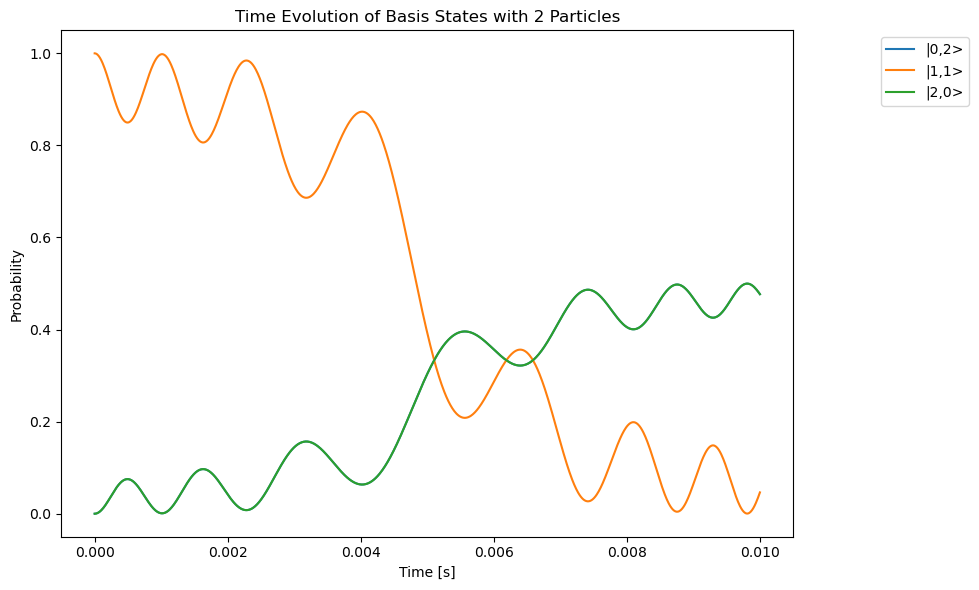

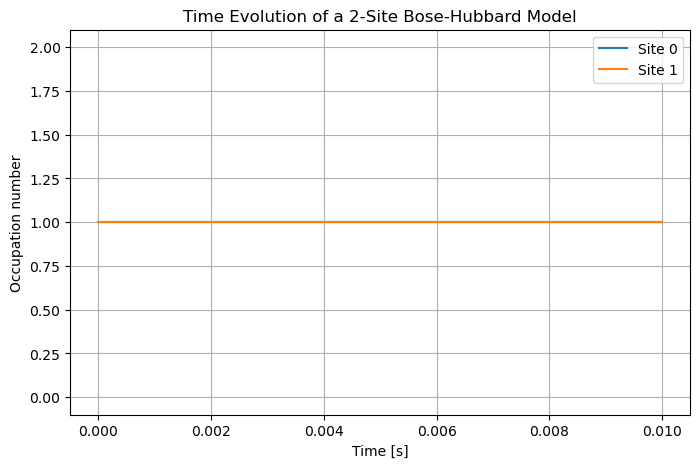

In [11]:
d=3

# --- Extracting and Plotting State Vector Components ---
# Create an array of states; each state is flattened into a 1D array of length d^2
states = np.array([state.full().flatten() for state in result.states])
# Compute probabilities: squared magnitude of each component
probs = np.abs(states)**2
fid = np.mean(probs[-int(N_steps/5):, 2] + probs[-int(N_steps/5):, 6])
print(f"fidelity: {fid:.3f}")

# Create labels for each basis state in the two-site Fock space
basis_labels = [f"|{n0},{n1}>" for n0 in range(d) for n1 in range(d)]
# Create a list of corresponding total particle numbers for each basis state
total_particles = [n0 + n1 for n0 in range(d) for n1 in range(d)]

# Filter indices for basis states with exactly 2 particles
indices_2particles = [idx for idx, tot in enumerate(total_particles) if tot == 2]
labels_2particles = [basis_labels[idx] for idx in indices_2particles]

# Plot the probability for each 2-particle basis state over time
plt.figure(figsize=(10, 6))
for idx, label in zip(indices_2particles, labels_2particles):
    plt.plot(tlist, probs[:, idx], label=label)
plt.xlabel('Time [s]')
plt.ylabel('Probability')
plt.title('Time Evolution of Basis States with 2 Particles')
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

# --- Plot the Results ---
plt.figure(figsize=(8, 5))
plt.plot(tlist, result.expect[0], label='Site 0')
plt.plot(tlist, result.expect[1], label='Site 1')
plt.ylim(-0.1,2.1)
plt.xlabel('Time [s]')
plt.ylabel('Occupation number')
plt.title('Time Evolution of a 2-Site Bose-Hubbard Model')
plt.legend()
plt.grid(True)
plt.show()

Try to see what different speeds do: